In [1]:
import pandas as pd
import category_encoders as ce
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [2]:
def preprocess(data, train=False):
    """Preprocess input data before training.

    Args:
        data (`pd.DataFrame`): The raw input dataframe
        train (bool): Whether the input contains the client retention flag

    Returns:
        `pd.DataFrame`: The preprocessed data for the model
        `pd.Series`: The corresponding preprocessed labels. This is only
            returned if the `train` argument is set to True.

    """
    # Client ID and Company ID are unnecessary
    data = data.drop(columns=["Client ID", "Company ID"])
    
    label = "Client Retention Flag"  # the field that is to be predicted
    if train:
        # The output field has ONLY two values: "Yes" and "No". Its value is
        # set to 1 (int form of bool True) if it is "Yes". If it is not "Yes",
        # it is "No", and thus it is set to 0 (int form of bool False).
        data[label] = data[label].apply(lambda x: int(x == "Yes"))
    
    # Replace categorical columns by one-hot encoded columns.
    # Here, each categorical column is dropped, and multiple columns - each
    # denoting a single feature of the one-hot encoded vector - are added
    # in-place.
    ce_col = list(data.select_dtypes(include=["object"]).columns)
    encoder = ce.OneHotEncoder(cols=ce_col)
    data = encoder.fit_transform(data)
    
    if train:
        # Return X, y
        return data.drop(columns=[label]), data[label]
    else:
        # Return only X
        return data

In [3]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")
X_train, y_train = preprocess(train_data, train=True)
X_test = preprocess(test_data)

In [4]:
# Hyperparams obtained using Hyperopt's hyperparam tuning methods
model =  XGBClassifier(
    base_score=0.5315979758590659,
    colsample_bytree=0.763171792007325,
    gamma=4.8396534022477855,
    learning_rate=0.26738381031741343,
    max_depth=20,
    n_estimators=200,
    random_state=3,  # for reproducibility
    reg_alpha=1.1573581164451705,
    reg_lambda=0.763295630042223,
    scale_pos_weight=1.6706777186920017,
    n_jobs=6,  # should be < no. of CPU cores, for efficiency
)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5315979758590659, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.763171792007325, gamma=4.8396534022477855,
              learning_rate=0.26738381031741343, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=6,
              nthread=None, objective='binary:logistic', random_state=3,
              reg_alpha=1.1573581164451705, reg_lambda=0.763295630042223,
              scale_pos_weight=1.6706777186920017, seed=None, silent=None,
              subsample=1, verbosity=1)

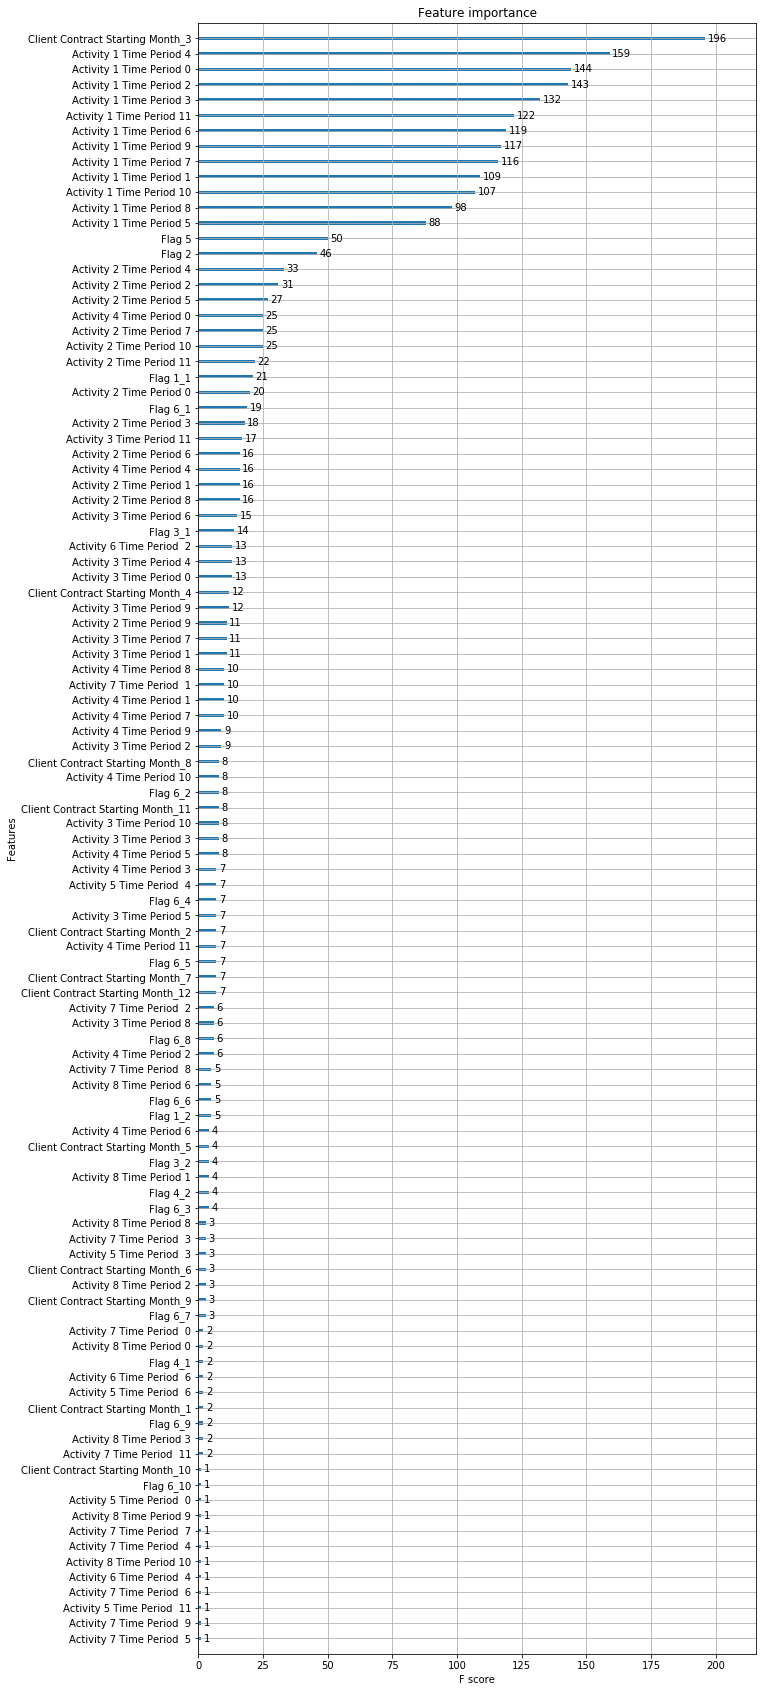

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 30))
plot_importance(model, ax=ax)
fig.savefig("feature-importance.png", bbox_inches="tight")

In [6]:
def postprocess(pred, test_data):
    """Postprocess the model's outputs before exporting.

    Args:
        pred (`numpy.ndarray`): The model's outputs
        test_data (`pd.DataFrame`): The corresponding test data given to the
            model

    Returns:
        `pd.DataFrame`: The processed outputs for exporting to a CSV

    """
    label = "Client Retention Flag"
    # There is only one unnamed column, so its name is 0
    pred = pred.rename(columns={0: label})
    # Map the model's outputs (which are float values) to their meaning
    pred[label] = pred[label].apply(lambda x: "Yes" if x == 1.0 else "No")

    # This is required as by default pandas will insert the "Client ID"
    # column at the end of the DataFrame.
    # NOTE: This assumes that the order of the clients is not altered anywhere.
    pred.insert(loc=0, column="Client ID", value=test_data["Client ID"])
    return pred

In [7]:
y_pred = pd.DataFrame(model.predict(X_test))
y_pred = postprocess(y_pred, test_data)
y_pred.to_csv("Submission.csv", index=False)